# Real-time adaptive filtering using least-mean-squares (LMS)

Code adapted from `padasip` library: (http://matousc89.github.io/padasip/)

## Questions

- Why does stability of LMS depend so much on learning rate?
- Why is LMS filter not working on Steinmetz data?

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

## Implement LMS filter for multidimensional signal

In [2]:
class FilterLMS:
    """This class represents an adaptive LMS filter.
    
    Args:
        dim (int): Dimension of signal
        order (int): Order of filter
        mu (float, optional): Learning rate. Also known as step size. If it is
            too slow, the filter may have bad performance. If it is too high,
            the filter will be unstable. The default value can be unstable for
            ill-conditioned input data.
        wts_init (str, optional): Method for initializing weights. Options are:
            - 'random': Create random weights
            - 'zeros': Create zero value weights
    """
    
    def __init__(self, dim, order, mu=0.01, wts_init='random'):
        
        self.dim = self._check_int_param(dim, 0, None)
        self.order = self._check_int_param(order, 0, None)
        self.mu = self._check_float_param(mu, 0, 1000)
        self.wts_shape = (self.dim, self.order * self.dim)
        
        if wts_init == 'random':
            self.wts = np.random.normal(0, 0.5, self.wts_shape)
        elif wts_init == 'zeros':
            self.wts = np.zeros(self.wts_shape)
        else:
            raise ValueError(f'"{wts_init}" not valid option for weight init')
        
    @staticmethod
    def _check_int_param(param, lo, hi):
        """Check if parameter is int and within given range.
        
        Args:
            param (convertible to int): Parameter to check
            lo (int): Lowest allowed value, or None
            hi (int): Highest allowed value, or None
            
        Returns:
            (int): Parameter converted to int
        """
        
        try:
            param = int(param)            
        except ValueError:
            raise ValueError('Parameter is not int or similar')
        else:
            if lo is None:
                lo = float('-inf')
            if hi is None:
                hi = float('inf')
            if not lo <= param <= hi:
                raise ValueError('Parameter is not in range')
            return param
    
    @staticmethod
    def _check_float_param(param, lo, hi):
        """Check if parameter is float and within given range.
        
        Args:
            param (convertible to float): Parameter to check
            lo (float): Lowest allowed value, or None
            hi (float): Highest allowed value, or None
            
        Returns:
            (float): Parameter converted to float
        """
        
        try:
            param = float(param)            
        except ValueError:
            raise ValueError('Parameter is not float or similar')
        else:
            if lo is None:
                lo = float('-inf')
            if hi is None:
                hi = float('inf')
            if not lo <= param <= hi:
                raise ValueError('Parameter is not in range')
            return param
    
    @staticmethod
    def _input_to_vec(x):
        """Convert input matrix to vector."""
        
        return x.reshape(-1, 1)
        
    def adapt(self, d, x):
        """Adapt weights using desired value and its input.
        
        Args:
            d (dim*1 array): Desired value
            x (dim*1 array): Input array
        """
        
        x_vec = self._input_to_vec(x)
        y = self.wts @ x_vec
        e = d - y
        
        self.wts += self.mu * e @ x_vec.T 

    def predict(self, x):
        """Predict output for given input using current filter state.
        
        Args:
            x (dim*order array): Filter input matrix. Each column is a signal
                value for a given time.
        Returns:
            (dim*1 array): Output vector.
        """
        
        return self.wts @ self._input_to_vec(x)

## Test filter on synthetic data with random input

In [3]:
dim = 2
order = 2

def measure_x():
    return np.random.random((dim, order))
    
def measure_d(x):
    w_1 = 2 * np.eye(2)
    w_2 = -1 * np.ones(2)
    return w_1 @ x[:, 0].reshape(-1, 1) + w_2 @ x[:, 1].reshape(-1, 1)

# Create LMS filter
flt = FilterLMS(dim, order, mu=1.0)

# Run filter and log results
n_pts = 100
d_vals = np.zeros((dim, n_pts))
y_vals = np.zeros((dim, n_pts))

for k in range(n_pts):
    
    # Single filter step
    x = measure_x()
    y = flt.predict(x)
    d = measure_d(x)
    flt.adapt(d, x)
    
    # Log values
    d_vals[:, k] = d.reshape(-1)
    y_vals[:, k] = y.reshape(-1)

# Compute Euclidean error
err = np.sum((y_vals - d_vals) ** 2, 0) ** 0.5

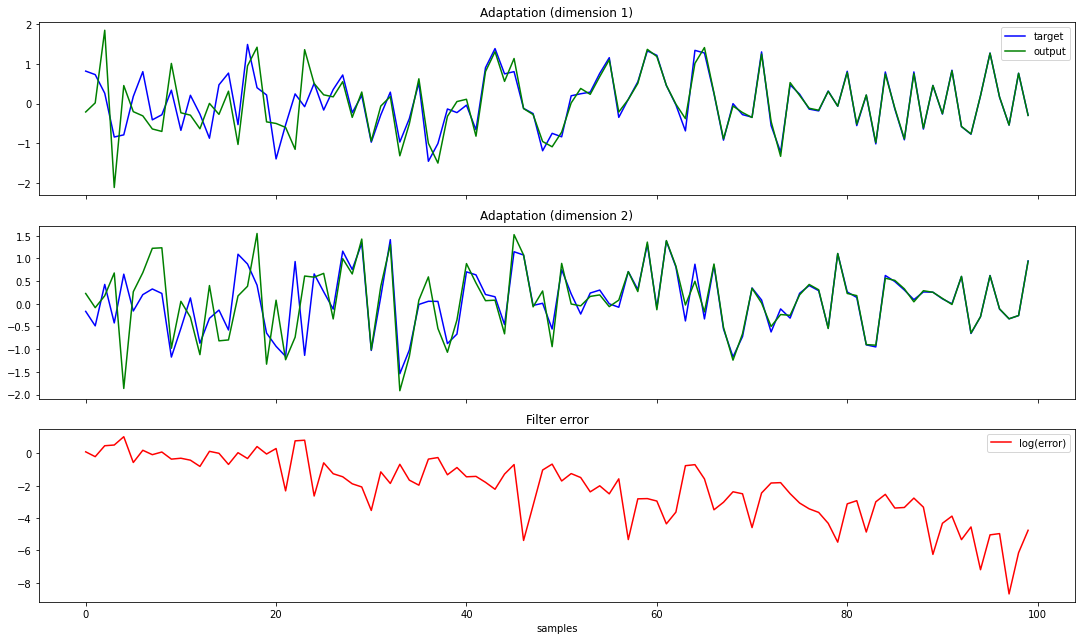

In [4]:
fig, (ax_1, ax_2, ax_3) = plt.subplots(3, 1, figsize=(15, 9), sharex=True)

ax_1.set_title('Adaptation (dimension 1)')
ax_1.plot(d_vals[0, :], 'b', label='target')
ax_1.plot(y_vals[0, :], 'g', label='output')
ax_1.legend()

ax_2.set_title('Adaptation (dimension 2)')
ax_2.plot(d_vals[1, :], 'b')
ax_2.plot(y_vals[1, :], 'g')

ax_3.set_title('Filter error')
ax_3.plot(np.log(err), 'r', label='log(error)')
ax_3.set_xlabel('samples')
ax_3.legend()

plt.tight_layout()

## Test filter on synthetic vector autoregressive (VAR) process

In [5]:
class FilterAutoLMS:
    """This class implements a LMS filter on an autoregressive process.

    It maintains a history of signal values of size `order`, and uses this
    history as the input for the LMS filter, which is trained to predict the
    next value of the time series.
    
    Args:
        dim (int): Dimension of signal
        order (int): Order of filter
        mu (float, optional): Learning rate. Also known as step size. If it is
            too slow, the filter may have bad performance. If it is too high,
            the filter will be unstable. The default value can be unstable for
            ill-conditioned input data.
        wts_init (str, optional): Method for initializing weights. Options are:
            - 'random': Create random weights
            - 'zeros': Create zero value weights
    """
 

    def __init__(self, dim, order, mu=0.01, wts_init='random'):

        self.flt_lms = FilterLMS(dim, order, mu=mu, wts_init='random')
        self.x_hist = np.zeros((dim, order))

    def predict_next(self, x):
        """Update filter with new signal value and predict next value.

        Args:
            x (dim*1 array): New signal value

        Returns:
            (dim*1 array): Predicted next signal value
        """

        # Update filter using history as input and current value as output
        self.flt_lms.adapt(x, self.x_hist)

        # Add current value to history, dropping oldest value
        self.x_hist = np.concatenate([x, self.x_hist[:, 0:-1]], axis=1)

        # Use new history to predict next value
        return self.flt_lms.predict(self.x_hist)

In [6]:
# Basic parameters
dim = 2
order = 2

# VAR parameters (TODO: Set second matrix to nonzero value!)
theta = 0.01
w_1 = 0.999 * np.array([
    [np.cos(theta), -np.sin(theta)],
    [np.sin(theta), np.cos(theta)]
])
w_2 = 0.0 * np.eye(2)
sigma = 1.0

def gen_var(n_pts):
    """Generator for VAR process."""
    
    # Initialize history values to zeros
    x_1 = np.zeros((dim, 1))
    x_2 = np.zeros((dim, 1))
    
    for i in range(n_pts):
        
        # Compute next term in sequence
        x = w_1 @ x_1 + w_2 @ x_2 + sigma * np.random.randn(dim, 1)
        yield x
        
        # Update history values
        x_2 = x_1
        x_1 = x

# Create LMS filter
flt = FilterAutoLMS(dim, order, mu=1e-4, wts_init='random')

# Run filter and log results
n_pts = 600
signal_gen = gen_var(n_pts)
d_vals = np.zeros((dim, n_pts))
y_vals = np.zeros((dim, n_pts))

x = np.zeros((dim, 1))
for k in range(n_pts):
    
    y = flt.predict_next(x)
    x = next(signal_gen)
    
    # Log values
    y_vals[:, k] = y.reshape(-1)
    d_vals[:, k] = x.reshape(-1)

# Compute Euclidean error
err = np.sum((y_vals - d_vals) ** 2, 0) ** 0.5

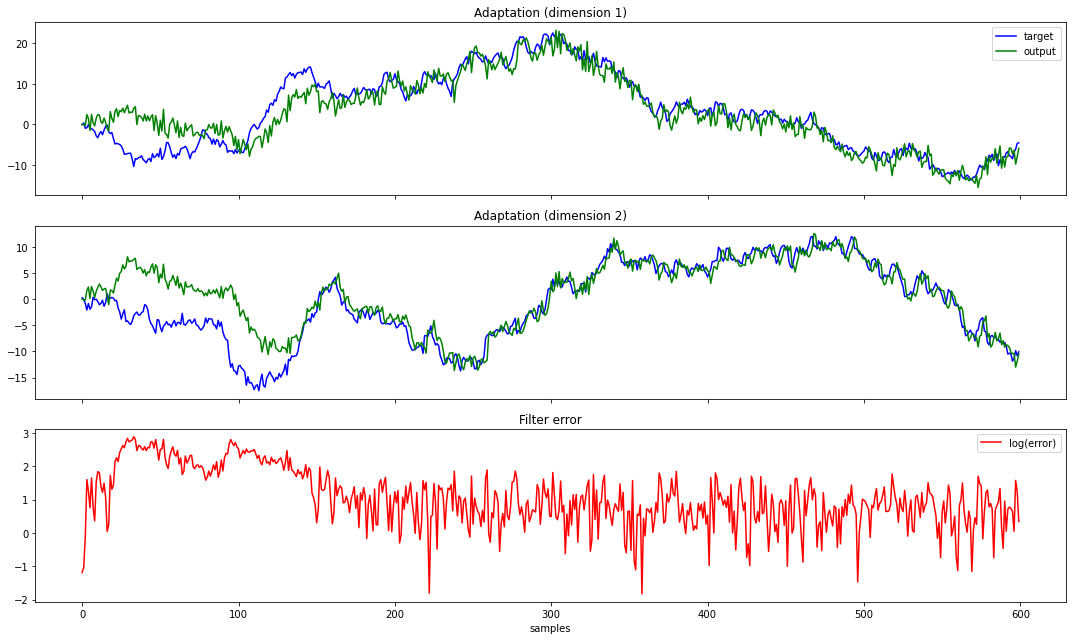

In [7]:
fig, (ax_1, ax_2, ax_3) = plt.subplots(3, 1, figsize=(15, 9), sharex=True)

ax_1.set_title('Adaptation (dimension 1)')
ax_1.plot(d_vals[0, :], 'b', label='target')
ax_1.plot(y_vals[0, :], 'g', label='output')
ax_1.legend()

ax_2.set_title('Adaptation (dimension 2)')
ax_2.plot(d_vals[1, :], 'b')
ax_2.plot(y_vals[1, :], 'g')

ax_3.set_title('Filter error')
ax_3.plot(np.log(err), 'r', label='log(error)')
ax_3.set_xlabel('samples')
ax_3.legend()

plt.tight_layout()

## Test filter on Steinmetz data

In [8]:
data_fpath = '/Users/cmcgrory/park_lab/realtime/basic_prototype/data/processed/r11_spks.h5'
with h5py.File(data_fpath, 'r') as f:
    spks = f['spks'][:]
    dim = spks.shape[0]

In [9]:
# Set order for filter
order = 10

# Set number of points to run for
n_pts = 1000

# Create LMS filter
flt = FilterLMS(dim, order, mu=0.005, wts_init='zeros')

# Run filter and log results
d_vals = np.zeros((dim, n_pts))
y_vals = np.zeros((dim, n_pts))

for k in range(n_pts):
    
    t = k + order
    
    # Filter input is previous signal values
    x = spks[:, (t-order):t]
    
    # Desired filter output is next value
    d = spks[:, t].reshape(-1, 1)
    
    # Single filter step
    y = flt.predict(x)
    flt.adapt(d, x)
    
    # Log values
    d_vals[:, k] = d.reshape(-1)
    y_vals[:, k] = y.reshape(-1)

# Compute Euclidean error
err = np.sqrt(np.sum((y_vals - d_vals) ** 2, 0))

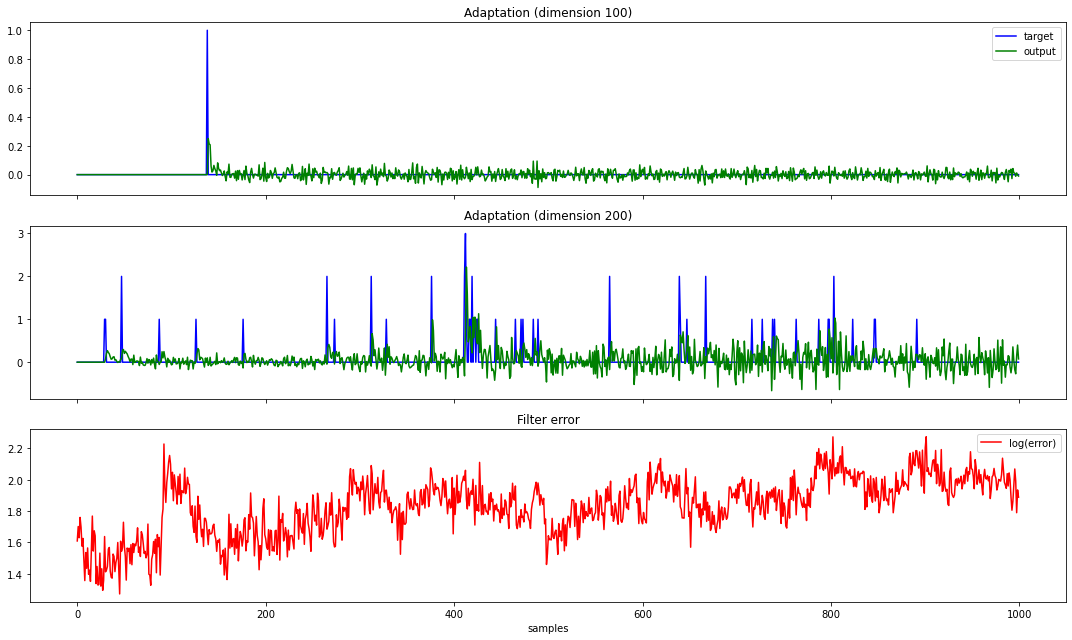

In [10]:
plot_dim_1 = 100
plot_dim_2 = 200

fig, (ax_1, ax_2, ax_3) = plt.subplots(3, 1, figsize=(15, 9), sharex=True)

ax_1.set_title(f'Adaptation (dimension {plot_dim_1})')
ax_1.plot(d_vals[plot_dim_1, :], 'b', label='target')
ax_1.plot(y_vals[plot_dim_1, :], 'g', label='output')
ax_1.legend()

ax_2.set_title(f'Adaptation (dimension {plot_dim_2})')
ax_2.plot(d_vals[plot_dim_2, :], 'b')
ax_2.plot(y_vals[plot_dim_2, :], 'g')

ax_3.set_title('Filter error')
ax_3.plot(np.log(err), 'r', label='log(error)')
ax_3.set_xlabel('samples')
ax_3.legend()

plt.tight_layout()